# Experiment 9: Implementing a Neural Network and Backpropagation from Scratch


This notebook implements a small feedforward neural network trained with backpropagation from scratch using only NumPy for the core computations. It follows the tasks provided in the assignment:

- Task 1: Data Loading and Preprocessing
- Task 2: From-Scratch Utilities (activations, derivatives, losses)
- Task 3: Build `MyANNClassifier` — a neural network class
- Task 4: Training and Experimentation (three configurations)
- Task 5: Comparison with scikit-learn's `MLPClassifier`

Required libraries: `numpy`, `pandas`, `matplotlib`, `seaborn`, `scikit-learn`.


In [1]:
# Task 0: Imports and global settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier

sns.set(style='whitegrid')
np.random.seed(42)


## Task 1: Data Loading and Preprocessing (15 Marks)

1. Load the Breast Cancer Wisconsin dataset using `sklearn.datasets`.
2. Display shapes and feature names.
3. Split 70/30 (random_state=42).
4. Standardize features (fit scaler on training set, transform both sets).


In [3]:
# Load dataset
data = load_breast_cancer()
X = data.data    # shape (n_samples, n_features)
y = data.target  # shape (n_samples,)

print('X shape:', X.shape)
print('y shape:', y.shape)
print('\nFeature names (first 10):', data.feature_names[:10])
print('\nAll feature names:')
for i, fn in enumerate(data.feature_names):
    print(f"{i+1:2d}. {fn}")

# Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print('\nAfter split:')
print('X_train:', X_train.shape, 'X_test:', X_test.shape)

# Standardize features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('\nPreprocessing complete.')


X shape: (569, 30)
y shape: (569,)

Feature names (first 10): ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension']

All feature names:
 1. mean radius
 2. mean texture
 3. mean perimeter
 4. mean area
 5. mean smoothness
 6. mean compactness
 7. mean concavity
 8. mean concave points
 9. mean symmetry
10. mean fractal dimension
11. radius error
12. texture error
13. perimeter error
14. area error
15. smoothness error
16. compactness error
17. concavity error
18. concave points error
19. symmetry error
20. fractal dimension error
21. worst radius
22. worst texture
23. worst perimeter
24. worst area
25. worst smoothness
26. worst compactness
27. worst concavity
28. worst concave points
29. worst symmetry
30. worst fractal dimension

After split:
X_train: (398, 30) X_test: (171, 30)

Preprocessing complete.


## Task 2: 'From Scratch' Utilities (20 Marks)

Implement activation functions, their derivatives, and loss functions using only NumPy:

- `sigmoid(Z)`, `relu(Z)`
- `sigmoid_derivative(A)`, `relu_derivative(Z)`
- `compute_bce_loss(Y, Y_hat)`
- `compute_mse_loss(Y, Y_hat)`

Notes:
- `sigmoid_derivative` will accept activated values `A` (sigmoid outputs) and compute `A * (1 - A)`.
- We will carefully handle shapes: all internal computations use arrays shaped `(n_units, m)` where `m` is batch size.


In [5]:
# Task 2: Implement utilities using NumPy

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def sigmoid_derivative(A):
    return A * (1 - A)

def relu_derivative(Z):
    dZ = np.zeros_like(Z)
    dZ[Z > 0] = 1
    return dZ

def compute_bce_loss(Y, Y_hat):
    eps = 1e-8
    Y_hat_clipped = np.clip(Y_hat, eps, 1 - eps)
    m = Y.shape[1]
    loss = - (1 / m) * np.sum(Y * np.log(Y_hat_clipped) + (1 - Y) * np.log(1 - Y_hat_clipped))
    return loss

def compute_mse_loss(Y, Y_hat):
    m = Y.shape[1]
    loss = (1 / (2 * m)) * np.sum((Y_hat - Y) ** 2)
    return loss

# Quick sanity checks
Z = np.array([[0.0, -1.0, 2.0]])
A_sig = sigmoid(Z)
print('sigmoid\n', A_sig)
print('sigmoid_derivative\n', sigmoid_derivative(A_sig))
print('relu\n', relu(Z))
print('relu_derivative\n', relu_derivative(Z))


sigmoid
 [[0.5        0.26894142 0.88079708]]
sigmoid_derivative
 [[0.25       0.19661193 0.10499359]]
relu
 [[0. 0. 2.]]
relu_derivative
 [[0. 0. 1.]]


## Task 3: Build 'From Scratch' ANN Classifier (40 Marks)

Implement `MyANNClassifier` with methods described in the instructions. Design decisions:

- `layer_dims` should include input size as the first element and output (1) as the last element, e.g. `[30, 10, 1]`.
- Parameters use small random initialization: `np.random.randn(...) * 0.01` and zero biases.
- Hidden layers: ReLU; Output layer: Sigmoid.
- Supports `loss='bce'` or `loss='mse'`.
- Tracks training cost in `.costs_` list.


In [6]:
class MyANNClassifier:
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce', print_every=100):
        # layer_dims: list like [n_x, n_h1, n_h2, ..., 1]
        self.layer_dims = list(layer_dims)
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        assert loss in ('bce', 'mse'), "loss must be 'bce' or 'mse'"
        self.loss = loss
        self.params = {}
        self.L = len(self.layer_dims) - 1  # number of layers (excluding input layer)
        self.costs_ = []
        self.print_every = print_every

    def _initialize_parameters(self):
        np.random.seed(42)
        params = {}
        for l in range(1, len(self.layer_dims)):
            n_l = self.layer_dims[l]
            n_prev = self.layer_dims[l-1]
            params['W' + str(l)] = np.random.randn(n_l, n_prev) * 0.01
            params['b' + str(l)] = np.zeros((n_l, 1))
        self.params = params

    def _forward_propagation(self, X):
        # X is expected shape (n_x, m)
        caches = {}
        A = X
        caches['A0'] = A
        for l in range(1, self.L + 1):
            W = self.params['W' + str(l)]
            b = self.params['b' + str(l)]
            Z = np.dot(W, A) + b
            caches['Z' + str(l)] = Z
            if l < self.L:  # hidden layers
                A = relu(Z)
            else:  # output layer
                A = sigmoid(Z)
            caches['A' + str(l)] = A
        return A, caches

    def _backward_propagation(self, Y, Y_hat, caches):
        grads = {}
        m = Y.shape[1]
        # Output layer gradient
        A_L = Y_hat
        if self.loss == 'bce':
            dZ = A_L - Y
        else:
            dA = A_L - Y
            dZ = dA * sigmoid_derivative(A_L)

        # grads for last layer
        dW = (1 / m) * np.dot(dZ, caches['A' + str(self.L - 1)].T)
        db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        grads['dW' + str(self.L)] = dW
        grads['db' + str(self.L)] = db
        dA_prev = np.dot(self.params['W' + str(self.L)].T, dZ)

        # Backprop through hidden layers
        for l in reversed(range(1, self.L)):
            Z = caches['Z' + str(l)]
            A_prev = caches['A' + str(l-1)]
            dZ = dA_prev * relu_derivative(Z)
            dW = (1 / m) * np.dot(dZ, A_prev.T)
            db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            grads['dW' + str(l)] = dW
            grads['db' + str(l)] = db
            dA_prev = np.dot(self.params['W' + str(l)].T, dZ)
        return grads

    def _update_parameters(self, grads):
        for l in range(1, self.L + 1):
            self.params['W' + str(l)] -= self.learning_rate * grads['dW' + str(l)]
            self.params['b' + str(l)] -= self.learning_rate * grads['db' + str(l)]

    def fit(self, X, y):
        """X shape: (n_samples, n_features)
           y shape: (n_samples,)
        """
        X = X.T
        m = X.shape[1]
        # Ensure layer_dims is consistent with X
        if self.layer_dims[0] != X.shape[0]:
            self.layer_dims = [X.shape[0]] + self.layer_dims
            self.L = len(self.layer_dims) - 1

        Y = y.reshape(1, -1)

        # Initialize
        self._initialize_parameters()
        self.costs_ = []

        for i in range(1, self.n_iterations + 1):
            # Forward
            Y_hat, caches = self._forward_propagation(X)

            # Compute cost
            if self.loss == 'bce':
                cost = compute_bce_loss(Y, Y_hat)
            else:
                cost = compute_mse_loss(Y, Y_hat)
            self.costs_.append(cost)

            # Backprop
            grads = self._backward_propagation(Y, Y_hat, caches)

            # Update
            self._update_parameters(grads)

            if self.print_every and (i % self.print_every == 0 or i == 1):
                print(f"Iteration {i}/{self.n_iterations} - cost: {cost:.6f}")

        return self

    def predict_proba(self, X):
        X = X.T
        Y_hat, _ = self._forward_propagation(X)
        return Y_hat.ravel()

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs >= 0.5).astype(int)

print('MyANNClassifier defined.')


MyANNClassifier defined.


## Task 4: Training and Experimentation (15 Marks)

Train three configurations:
1. Model 1: BCE Loss, architecture [30, 10, 1]
2. Model 2: MSE Loss, architecture [30, 10, 1]
3. Model 3: BCE Loss, architecture [30, 10, 5, 1]

For each model:
- Fit on training data
- Predict on test data
- Display classification_report
- Plot loss curve


--- Model 1 - BCE [30,10,1] ---
Iteration 1/1000 - cost: 0.693178
Iteration 200/1000 - cost: 0.669382
Iteration 400/1000 - cost: 0.609172
Iteration 600/1000 - cost: 0.343289
Iteration 800/1000 - cost: 0.188577
Iteration 1000/1000 - cost: 0.135788

Classification report:
              precision    recall  f1-score   support

           0     0.9672    0.9219    0.9440        64
           1     0.9545    0.9813    0.9677       107

    accuracy                         0.9591       171
   macro avg     0.9609    0.9516    0.9559       171
weighted avg     0.9593    0.9591    0.9589       171

Accuracy: 0.9591


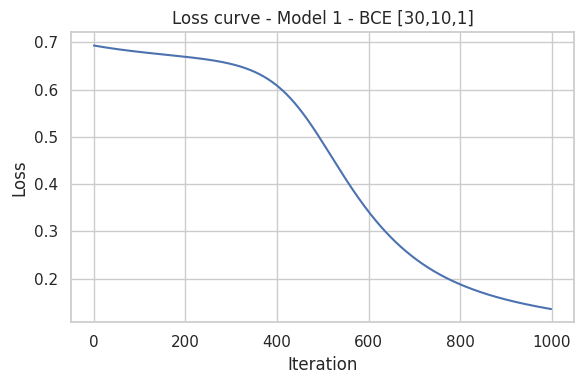

--- Model 2 - MSE [30,10,1] ---
Iteration 1/1000 - cost: 0.125008
Iteration 200/1000 - cost: 0.123133
Iteration 400/1000 - cost: 0.121619
Iteration 600/1000 - cost: 0.120328
Iteration 800/1000 - cost: 0.119080
Iteration 1000/1000 - cost: 0.117609

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        64
           1     0.6257    1.0000    0.7698       107

    accuracy                         0.6257       171
   macro avg     0.3129    0.5000    0.3849       171
weighted avg     0.3915    0.6257    0.4817       171

Accuracy: 0.6257


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


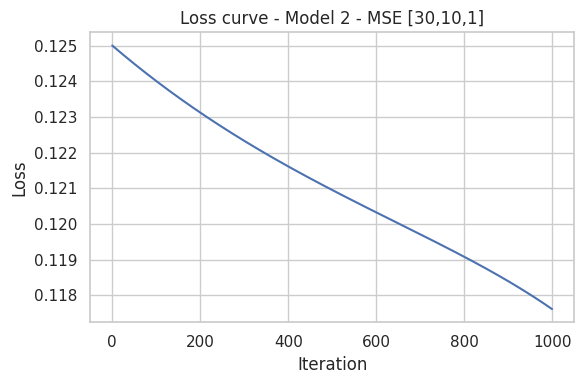

--- Model 3 - BCE [30,10,5,1] ---
Iteration 1/1000 - cost: 0.693145
Iteration 200/1000 - cost: 0.672412
Iteration 400/1000 - cost: 0.664665
Iteration 600/1000 - cost: 0.661748
Iteration 800/1000 - cost: 0.660635
Iteration 1000/1000 - cost: 0.660206

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        64
           1     0.6257    1.0000    0.7698       107

    accuracy                         0.6257       171
   macro avg     0.3129    0.5000    0.3849       171
weighted avg     0.3915    0.6257    0.4817       171

Accuracy: 0.6257


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


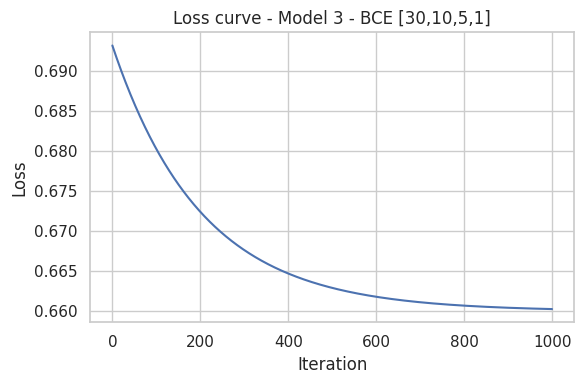

In [7]:
# Helper function to train and evaluate a model
from sklearn.metrics import classification_report

def train_and_evaluate(model, X_train, y_train, X_test, y_test, title='Model'):
    print('---', title, '---')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('\nClassification report:')
    print(classification_report(y_test, y_pred, digits=4))
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {acc:.4f}')

    # plot loss curve
    plt.figure(figsize=(6,4))
    plt.plot(model.costs_)
    plt.title(f'Loss curve - {title}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

# Prepare data
Xtr = X_train_scaled
Xte = X_test_scaled

# Model 1: BCE, [30, 10, 1]
model1 = MyANNClassifier(layer_dims=[30, 10, 1], learning_rate=0.01, n_iterations=1000, loss='bce', print_every=200)
train_and_evaluate(model1, Xtr, y_train, Xte, y_test, title='Model 1 - BCE [30,10,1]')

# Model 2: MSE, [30, 10, 1]
model2 = MyANNClassifier(layer_dims=[30, 10, 1], learning_rate=0.01, n_iterations=1000, loss='mse', print_every=200)
train_and_evaluate(model2, Xtr, y_train, Xte, y_test, title='Model 2 - MSE [30,10,1]')

# Model 3: BCE, [30, 10, 5, 1]
model3 = MyANNClassifier(layer_dims=[30, 10, 5, 1], learning_rate=0.01, n_iterations=1000, loss='bce', print_every=200)
train_and_evaluate(model3, Xtr, y_train, Xte, y_test, title='Model 3 - BCE [30,10,5,1]')


## Task 5: Comparison with scikit-learn (10 Marks)

Train an `MLPClassifier` with parameters similar to the best custom model and compare performance.


In [8]:
# Train scikit-learn's MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam',
                    learning_rate_init=0.001, max_iter=1000, random_state=42)
mlp.fit(Xtr, y_train)
y_pred_mlp = mlp.predict(Xte)
print('Classification report - sklearn MLPClassifier:')
print(classification_report(y_test, y_pred_mlp, digits=4))
print('Accuracy:', accuracy_score(y_test, y_pred_mlp))


Classification report - sklearn MLPClassifier:
              precision    recall  f1-score   support

           0     0.9545    0.9844    0.9692        64
           1     0.9905    0.9720    0.9811       107

    accuracy                         0.9766       171
   macro avg     0.9725    0.9782    0.9752       171
weighted avg     0.9770    0.9766    0.9767       171

Accuracy: 0.9766081871345029


### Final Notes

- This implementation is intentionally educational and minimal. Production-ready neural networks require improved initialization, regularization, vectorization optimizations, mini-batch training, different optimizers (Adam, RMSprop), learning-rate schedules, and careful numerical stability handling.
- You can experiment with learning rates, number of iterations, architectures, and batch training to improve performance.

**End of Notebook**
